<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Métricas para problemas de clasificación y regresión<a id="top"></a>

<i><small>Última actualización: 2025-02-27</small></i></div>

***

## Introducción

En un esquema de aprendizaje supervisado, el objetivo es modelar de algún modo la relación entre las características medidas de los datos y alguna etiqueta asociada a dichos datos. De esta manera, si se logra un modelo capaz de capturar la naturaleza de dicha relación, podremos usarlo para aplicar etiquetas a datos nuevos y desconocidos.

Este objetivo se da en dos tareas distintas, tanto en la definición de su arquitectura como en la medición de su rendimiento:

- **Tareas de regresión**, también llamadas tareas de ajuste, en las que **las etiquetas son cantidades continuas**, y
- **Tareas de clasificación**, en las que **las etiquetas son categorías discretas**.

El autor [Peter Drucker](https://es.wikipedia.org/wiki/Peter_F._Drucker) dijo una vez: «_No se puede mejorar lo que no se puede medir_». Aquí es donde las métricas resultan útiles: evalúan la eficacia con la que el algoritmo representa el conjunto de datos. Pero cada tarea diferente viene con su propio conjunto de métricas, y es interesante conocerlas para entender el estado de nuestro modelo predictivo.

## Objetivos

Propondremos soluciones a dos tipos diferentes de problemas, uno de clasificación y otro de regresión. Para ellos, también definiremos una serie de métricas para medir su rendimiento.

## Bibliotecas y configuración

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

#import torch.optim as optim

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [16]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({"axes.grid" : False})
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Problemas de regresión

Esta clase de problemas consiste en **predecir un valor continuo a partir de un conjunto de características de entrada**. Este enfoque se utiliza en múltiples aplicaciones, como la estimación de precios, la proyección de ventas o, como en el caso que nos ocupa, la evaluación de la progresión de una enfermedad.

En este ejemplo trabajaremos con el _dataset_ de diabetes, un conjunto de datos clínicos en el que se han registrado 10 variables relevantes sobre pacientes. Estas variables resumen información extraída de estudios médicos y reflejan distintos aspectos de la salud, tales como medidas relacionadas con la respuesta a la insulina y otros indicadores fisiológicos.

El objetivo es construir un modelo sencillo que, a partir de estas características, sea capaz de predecir la progresión de la diabetes un año después, representada por un valor numérico. Esta tarea ilustra cómo las técnicas de aprendizaje automático pueden aplicarse en el ámbito de la salud para identificar patrones y predecir la evolución de condiciones médicas.

In [17]:
# Cargamos el conjunto de datos de diabetes ...
data = sklearn.datasets.load_diabetes()
X = data.data
y = data.target
# ... y lo separamos en dos conjuntos, entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(
    X,  # Las entradas para los ejemplos de nuestro problema
    y,  # Sus salidas correspondientes
    test_size=0.2,  # Separación 80%/20%
    random_state=42,  # Para ayudar a la reproducibilidad
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

Training shape: torch.Size([353, 10]) input, torch.Size([353, 1]) output
Test shape:     torch.Size([89, 10]) input, torch.Size([89, 1]) output


Cuando entrenamos una red neuronal, alimentar el modelo directamente con los datos en bruto puede traernos algunos inconvenientes. Esto se debe a que las diferentes características pueden tener rangos de valores muy distintos, y aquellos con números mucho más altos tienden a «robar» el protagonismo durante el aprendizaje, haciendo que el modelo se enfoque en ellos y, en consecuencia, descuide otras variables que también pueden ser importantes. Esto no solo alarga el tiempo de entrenamiento, sino que también puede dificultar que el modelo encuentre una solución óptima, e incluso provocar problemas como el desvanecimiento o la explosión de gradientes.

Para evitar estos problemas y asegurar que cada característica aporte de manera equilibrada, es fundamental normalizar los datos antes de introducirlos en la red. Una técnica común es la normalización mediante la [puntuación estándar o _z-score_](https://en.wikipedia.org/wiki/Standard_score). Básicamente, se trata de restar la media de cada característica y dividir el resultado por su desviación estándar, de modo que todas las variables queden centradas alrededor de $0$ y con una desviación estándar de $1$. Este proceso equilibra la escala de los datos, aunque asume que cada característica sigue una distribución cercana a la normal. Si este no es el caso, puede ser necesario explorar otras técnicas de normalización o transformación para preparar adecuadamente los datos para el entrenamiento.

In [18]:
print(f"x_train example before: {x_train[1]}...")
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std  # Usamos los mismos parámetros de normalización
print(f"x_train example after: {x_train[1]}...")

x_train example before: tensor([-0.0091,  0.0507, -0.0181, -0.0332, -0.0208,  0.0122, -0.0729,  0.0712,
         0.0003,  0.0196])...
x_train example after: tensor([-0.2285,  1.0599, -0.4188, -0.7096, -0.4243,  0.2720, -1.5276,  1.4822,
        -0.0197,  0.3667])...


Crearemos un modelo de dos capas ocultas de $8$ neuronas cada una (activación ReLU), seguidas de una única neurona de salida (ya que vamos a predecir un único valor) y, aunque en muchos casos las salidas suelen estar normalizadas, en este caso la activación de la última neurona será lineal para no añadir complicación al modelo.

In [27]:
model = nn.Sequential(
    nn.LazyLinear(out_features=8),
    nn.ReLU(),
    nn.LazyLinear(out_features=8),
    nn.ReLU(),
    nn.LazyLinear(out_features=1),
)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters())

Sequential(
  (0): LazyLinear(in_features=0, out_features=8, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=8, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=1, bias=True)
)


Ahora, entrenaremos el modelo para ver cómo se comporta el proceso de entrenamiento. Para este proceso vamos a separar un pequeño conjunto que usaremos para la validación de nuestro modelo durante el entrenamiento.

In [28]:
val_split = 0.1
n_val = int(len(x_train) * val_split)
indices = torch.randperm(len(x_train))
val_indices = indices[:n_val]
train_indices = indices[n_val:]

x_train_final = x_train[train_indices]
y_train_final = y_train[train_indices]
x_val = x_train[val_indices]
y_val = y_train[val_indices]

epochs = 500
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_final)
    loss = criterion(y_pred, y_train_final)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val)
        val_loss = criterion(y_val_pred, y_val)
    val_losses.append(val_loss.item())

Ahora veamos cómo han evolucionado las pérdidas durante el entrenamiento

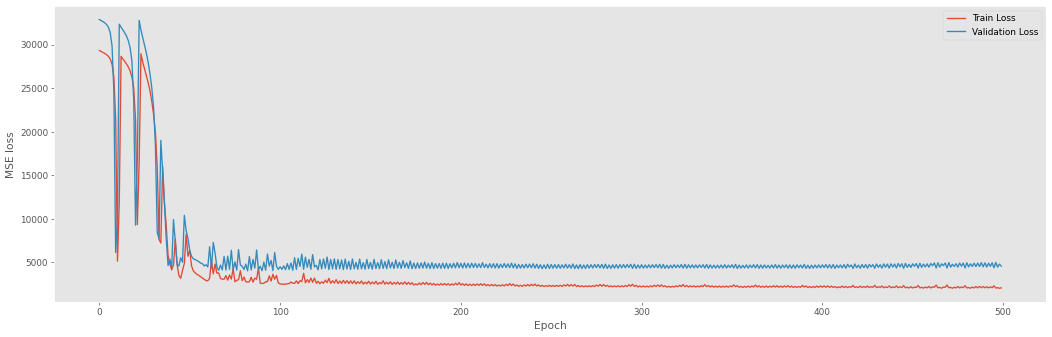

In [29]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

Un entrenamiento que nos muestra claramente que el modelo está sobreepecializado. No es el objetivo abordar esto ahora, es un problema para nuestro yo futuro. Ahora lo que haremos es predecir las salidas del conjunto de pruebas y a ponerlas frente a frente con las reales, para poder compararlas:

In [50]:
model.eval()
with torch.no_grad():
    ŷ_test = model(x_test)
    test_loss = criterion(ŷ_test, y_test)
    rmse_test = torch.sqrt(test_loss)
print("Test MSE loss:", test_loss.item())
print("Test RMSE:", rmse_test.item())

results = torch.cat((y_test, ŷ_test), dim=1).numpy()
print("Ground truth vs predicción (first 10 rows):")
print(results[:10])

Test MSE loss: 0.689786434173584
Test RMSE: 0.8305338025093079
Ground truth vs predicción (first 10 rows):
[[0.         0.52337575]
 [0.         0.55034983]
 [1.         0.5475082 ]
 [1.         0.5471172 ]
 [0.         0.5518676 ]
 [0.         0.52953416]
 [0.         0.53383887]
 [1.         0.5457926 ]
 [0.         0.55503416]
 [1.         0.54698575]]


A simple vista parece que el modelo no predice demasiado bien. Para ver cómo de bien, sacar conclusiones o, al menos, poder comparar entre modelos, existen diferentes métricas. Veamos algunas de las más conocidas:

### Error absoluto medio (MAE, del inglés _mean absolute error_)

Mide la media de las diferencias absolutas entre los valores previstos y los reales. La fórmula para calcular el MAE es

$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

siendo:

- $n$ el número de observaciones del conjunto de pruebas,
- $y_i$ el valor real de la $i$-ésima observación en el conjunto de prueba, y
- $\hat{y}_i$ el valor previsto de la observación $i$-ésima del conjunto de pruebas.

In [51]:
def mae(y, ŷ):
    return np.abs(y - ŷ).mean()

print(f'MAE = {mae(y_test, ŷ_test)}')

MAE = 0.49695971608161926


/tmp/ipykernel_115835/3629160036.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.abs(y - ŷ).mean()


El MAE es una métrica útil porque es interpretable y fácil de entender. Un valor MAE más bajo indica un mejor ajuste entre los valores previstos y los reales, y un valor 0 indica un ajuste perfecto.

También es menos sensible a los valores atípicos que otras métricas como el MSE, que eleva al cuadrado las diferencias entre los valores predichos y los reales, y puede verse muy influido por los valores extremos.

### Error cuadrático medio (MSE, del inglés _mean squared error_)

Mide la media de las diferencias al cuadrado entre los valores previstos y los reales. La fórmula para calcular el MSE es

$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

In [52]:
def mse(y, ŷ):
    return ((y - ŷ) ** 2).mean()

print(f'MSE = {mse(y_test, ŷ_test)}')

MSE = 0.2483247071504593


El MSE es una métrica útil porque penaliza más los errores grandes que los pequeños, debido a que eleva al cuadrado las diferencias entre los valores predichos y los reales.

Sin embargo, como implica elevar los errores al cuadrado, puede estar muy influenciado por valores atípicos y no ser tan interpretable como otras métricas como MAE. Un valor de MSE más bajo indica un mejor ajuste entre los valores predichos y los reales, y un valor de 0 indica un ajuste perfecto.

### Raíz del error cuadrático medio (RMSE, del inglés _root mean squared error_)

Mide la raíz cuadrada de la media de las diferencias al cuadrado entre los valores previstos y los reales. La fórmula para calcular el RMSE es:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

In [53]:
def rmse(y, ŷ):
    return mse(y, ŷ) ** .5

print(f'RMSE = {rmse(y_test, ŷ_test)}')

RMSE = 0.49832189083099365


El RMSE es una métrica útil porque tiene las mismas unidades que la variable que se predice, lo que facilita su interpretación.

También es menos sensible a los valores atípicos que el MSE, porque toma la raíz cuadrada de la suma de los errores al cuadrado, lo que ayuda a "deshacer" el efecto de cuadratura en los errores grandes. Un valor de RMSE más bajo indica un mejor ajuste entre los valores predichos y los reales, y un valor de 0 indica un ajuste perfecto.

### Coeficiente de determinación ($R^2$))

Mide qué porcentaje de la varianza de la variable dependiente ($y$, $\hat{y}$ e $\bar{y}$) explica el modelo de regresión que hemos ajustado.

Esto es, tenemos unos datos, y queremos ver cómo se relacionan con la variable que intentamos predecir. $R^2$ nos dice cuánto de esa variavión en los datos se logra explicar gracias a las variables que hemos incluido en nuestro modelo.

La fórmula para calcular $R^2$ es:

$$R^2(y, \hat{y}) = 1 - \frac{\sum_1^{n} (y_i - \hat{y}_i)^2}{\sum_1^{n}(y_i - \bar{y})^2}$$

In [54]:
def r2(y, ŷ):
    return 1 - ((y - ŷ) ** 2).sum() / ((y - y.mean()) ** 2).sum()

print(f'R² = {r2(y_test, ŷ_test)}')

R² = 0.006685078144073486


El resultado de $R^2$ se interpreta de la siguiente manera:

- $R^2 = 1$: El modelo **predice perfectamente los valores**, es decir, explica el 100% de la variación.
- $R^2 = 0$: El modelo **no explica nada**, y sería tan útil como predecir siempre la media de la variable.
- $R^2 < 0$: Aunque es raro, puede ocurrir cuando el modelo **es peor** que usar simplemente la media de los datos para predecir.

Es una métrica muy útil porque es fácil de interpretar y puede utilizarse para comparar el rendimiento de distintos modelos. Sin embargo, tiene algunas limitaciones, como no poder distinguir entre un buen ajuste y un ajuste excesivo, y verse afectado por el número de variables independientes del modelo.

## Problemas de clasificación

Como decíamos en la introducción, clasificar significa predecir etiquetas discretas. Esto nos lleva a considerar los diferentes tipos de problemas de clasificación que podemos encontrar:

- **Clasificación binaria**: Las etiquetas son dos y sólo dos. Por ejemplo, si queremos predecir si un paciente tiene o no una enfermedad.
- **Clasificación multiclase**: Las etiquetas son más de dos. Por ejemplo, si queremos predecir el tipo de tumor a partir de una imagen.
- **Clasificación multietiqueta**: Las etiquetas son más de dos y puede haber más de una etiqueta correcta. Por ejemplo, si queremos predecir el tipo de tumor a partir de una imagen y también queremos saber si el tumor es maligno o benigno.

Diferentes tipos de problemas requieren diferentes formas de abordar cómo se está produciendo el error. En esta sección veremos cómo abordar cada uno de estos problemas.

### Clasificación binaria

En este caso intentaremos resolver un problema de clasificación binaria con un modelo sencillo para ilustrar el problema. Para ello aprovecharemos la función `make_classification` de la librería `scikit-learn`.

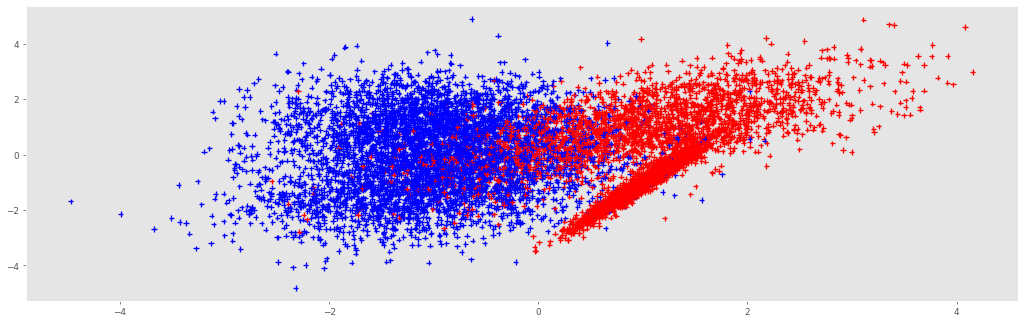

In [55]:
X, Y = sklearn.datasets.make_classification(
    n_samples=10000,
    n_features=2,
    n_redundant=0,
    n_classes=2
)
plt.scatter(X[:,0], X[:,1], marker="+", c=Y, cmap='bwr');

Ahora dividiremos el conjunto en el conjunto de entrenamiento, con el 90% de los puntos, y el conjunto de prueba, con el 10% restante.

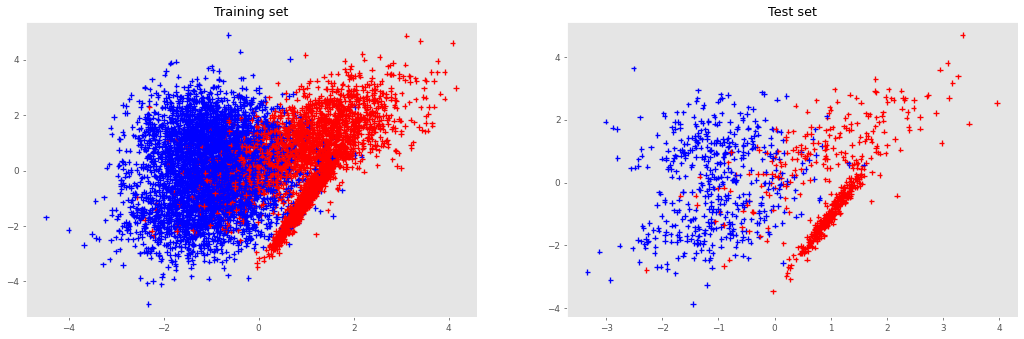

In [56]:
x_train, y_train = X[:-1000,:], Y[:-1000]
x_test, y_test = X[-1000:,:], Y[-1000:]

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:,0], x_train[:,1], marker="+", c=y_train, cmap='bwr');
plt.title('Training set')
plt.subplot(1, 2, 2)
plt.scatter(x_test[:,0], x_test[:,1], marker="+", c=y_test, cmap='bwr');
plt.title('Test set');

#### El modelo de clasificación

Ahora crearemos un modelo capaz de clasificar valores procedentes de esta distribución. La arquitectura es indiferente, pero lo importante es que la salida es una única neurona con función de activación sigmoide:

In [60]:
model = nn.Sequential(
    nn.LazyLinear(out_features=32),
    nn.ReLU(),
    nn.LazyLinear(out_features=16),
    nn.ReLU(),
    nn.LazyLinear(out_features=1),
    nn.Sigmoid(),
)
print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters())

Sequential(
  (0): LazyLinear(in_features=0, out_features=32, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=16, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=1, bias=True)
  (5): Sigmoid()
)


Ahora entrenemos el modelo:

In [61]:
val_split = 0.1
n_val = int(len(x_train) * val_split)
indices = torch.randperm(len(x_train))
val_indices = indices[:n_val]
train_indices = indices[n_val:]

x_train_final = x_train[train_indices]
y_train_final = y_train[train_indices]
x_val = x_train[val_indices]
y_val = y_train[val_indices]

epochs = 500
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_final)
    loss = criterion(y_pred, y_train_final)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val)
        val_loss = criterion(y_val_pred, y_val)
    val_losses.append(val_loss.item())

Veamos cómo ha evolucionado el proceso de entrenamiento:

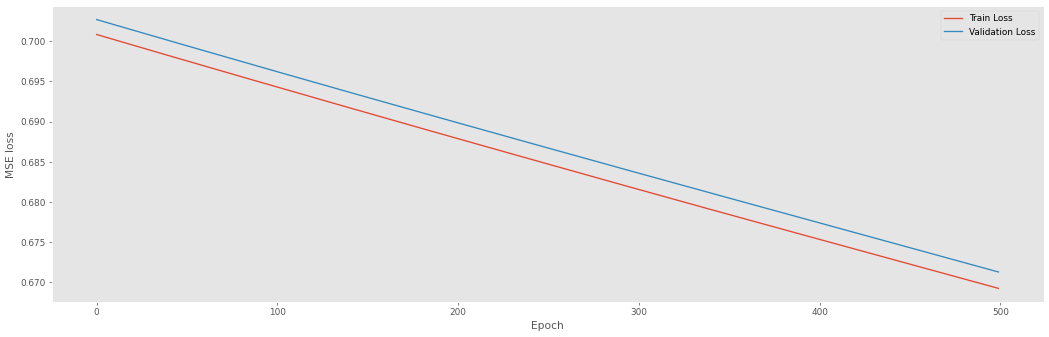

In [62]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.show()

Recorramos algunas de las diferentes métricas que existen para evaluar un modelo de clasificación. Para ello, extraeremos las predicciones de nuestro modelo sobre el conjunto de pruebas.

In [63]:
model.eval()
with torch.no_grad():
    ŷ_test = (model(x_test) >= 0.5).float()
    test_loss = criterion(ŷ_test, y_test)
print("Test binary cross entropy loss:", test_loss.item())

results = torch.cat((y_test, ŷ_test), dim=1).numpy()
print("Ground truth vs predicción (first 10 rows):")
print(results[:10])

Test binary cross entropy loss: 41.20000076293945
Ground truth vs predicción (first 10 rows):
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


En adelante nos conviene trabajar con las respuestas como array y no como tensores, así que extraeremos las respuestas a arrays de numpy

In [68]:
y_test = y_test.cpu().detach().numpy()
ŷ_test = ŷ_test.cpu().detach().numpy()

#### Matriz de confusión

No es una métrica como tal, sino una tabla que se utiliza en problemas de clasificación para evaluar dónde se han cometido errores en el modelo. Se utiliza para problemas de clasificación en los que la salida puede ser de dos o más tipos de clases, aunque aquí la explicaremos para problemas de clasificación binaria (de dos clases).

La idea es que las filas representan las clases reales que deberían haber sido los resultados, mientras que las columnas representan las predicciones que hemos hecho. Utilizando esta tabla es fácil identificar qué predicciones son erróneas.

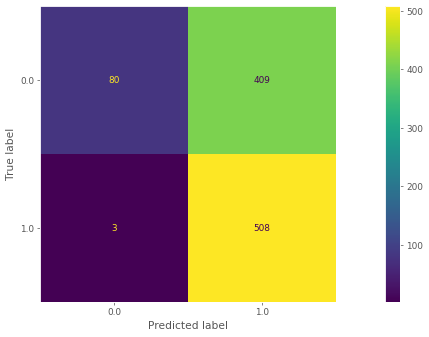

In [69]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_test, ŷ_test
)
plt.show()

Prácticamente todas las métricas de rendimiento en problemas de clasificación se basan en los valores de esta matriz. Antes de explicar estas métricas, conviene conocer los nombres por los que se conocen los valores de acierto y error:

1. **Verdaderos positivos** ($TP$, del inglés _true positives_): Aquellos casos en los que la clase real y la predicha por el modelo son verdaderas. Por ejemplo, el caso en el que una persona tiene cáncer (`true`) y el modelo clasifica su caso como cáncer (`true`).
2. **Verdaderos negativos** ($TN$, del inglés _true negatives_): Aquellos casos en los que la clase real y la clase predicha por el modelo son falsas. Por ejemplo, el caso en que una persona **no** tiene cáncer (`falso`) y el modelo clasifica su caso como **no** tiene cáncer (`falso`).
3. **Falsos positivos** ($FP$, del inglés _false positives_): Aquellos casos en los que la clase real es falsa, pero el modelo la predice como verdadera. Por ejemplo, una persona que **no** tiene cáncer, pero cuyo caso el modelo predice que tiene cáncer.
4. **Falsos negativos** ($FN$, _false negatives_): Aquellos casos en los que la clase real es verdadera, pero la predicha por el modelo es falsa. Por ejemplo, el caso de una persona que sí tiene cáncer, pero para la que el modelo predice que no lo tiene.

Por supuesto, buscamos el escenario en el que haya $0$ falsos positivos y $0$ falsos negativos, pero en la vida real no es así, ya que prácticamente ningún modelo será preciso al $100\%$. Por lo tanto, siempre habrá algún error asociado a cada modelo que utilicemos para predecir la clase real de la variable objetivo. Esto dará lugar a falsos positivos y falsos negativos, que también estarán relacionados: cuando unos disminuyan otros aumentarán y viceversa.

Así que cuáles son preferibles depende del problema:

1. **Minimizar los falsos negativos**: Suele ser aconsejable en casos en los que pasar por alto un caso positivo es un gran error. En el caso de la detección previa de un cáncer, es preferible cometer el error de un falso positivo (al paciente se le diagnostica un cáncer cuando no lo tiene) que un falso negativo (no se le diagnostica cuando sí lo tiene), porque en este último caso no se realizaría ningún examen más.
2. **Minimizar los falsos positivos**: Suele ser preferible en el caso contrario. Por ejemplo, en un caso de detección de spam, suele ser preferible que un correo basura no sea detectado como tal; si en este caso minimizamos los falsos negativos, los falsos positivos aumentarían y por tanto nuestro sistema podría eliminar correos auténticos.

#### Exactitud (_accuracy_)

Mide la proporción de instancias clasificadas correctamente sobre el número total de instancias del conjunto de datos. La fórmula para calcular la precisión es:

$$
Acc = \frac{TP + TN}{TP + FP + TN + FN}
$$

Es decir, el número de casos clasificados correctamente ($TP$ y $TN$) dividido por el número total de casos ($TP$, $TN$, $FP$ y $FN$). Responde a la pregunta: **¿Con qué frecuencia acierta el modelo?**

In [70]:
def accuracy(y, ŷ):
    return np.sum(y == ŷ) / len(y)

print(f'Accuracy = {accuracy(y_test, ŷ_test):.02}')

Accuracy = 0.59


La precisión es una métrica sencilla e intuitiva, fácil de entender e interpretar. Sin embargo, puede que no sea la mejor métrica en todos los casos, sobre todo cuando las clases del conjunto de datos están desequilibradas.

Por ejemplo, si estamos evaluando si se va a producir una fusión del núcleo de una central nuclear, un modelo que aprenda a decir siempre que no puede acertar el $99,9999999\%$ de las veces; desde el punto de vista de la precisión, el modelo está bien, pero siendo objetivo no vale para nada. En estos casos, otras métricas como la precisión, el recuerdo o la puntuación F1 pueden ser más apropiadas.

#### Precision

Mide la proporción de predicciones positivas verdaderas (es decir, el número de instancias clasificadas correctamente como positivas) de todas las predicciones positivas realizadas por el modelo (es decir, la suma de predicciones positivas verdaderas y falsas positivas). La fórmula para calcular la precisión es:

$$
Pre = \frac{TP}{TP + FP}
$$

Responde a la pregunta: **De los positivos predichos, ¿qué porcentaje es realmente positivo?

In [71]:
def precision(y, ŷ):
    TP = np.sum((ŷ_test == 1) & (y_test == 1))
    FP = np.sum((ŷ_test == 1) & (y_test == 0))
    return TP / (TP + FP)

print(f'Precision = {precision(y_test, ŷ_test):.02}')

Precision = 0.55


Es una métrica útil cuando queremos minimizar los falsos positivos, es decir, cuando queremos asegurarnos de que las instancias que clasificamos como positivas lo son realmente. Por ejemplo, supongamos que tenemos un modelo de clasificación binario que predice si un determinado correo electrónico es spam o no. Si el modelo predice que $100$ correos electrónicos son spam y $80$ de esas predicciones son correctas, mientras que $20$ son incorrectas, la precisión es de $0,8$, lo que significa que de todos los correos electrónicos predichos como spam por el modelo, el $80\%$ eran realmente spam.

Sin embargo, la precisión por sí sola puede no ser suficiente para evaluar el rendimiento de un modelo, y debe utilizarse junto con otras métricas como _recall_ o la puntuación F1.

#### Recuperación (_recall_)

También conocida como _sensitivity_, es una métrica que mide la proporción de predicciones positivas verdaderas (es decir, el número de instancias clasificadas correctamente como positivas) de todas las instancias positivas reales del conjunto de datos. La fórmula para calcular el recuerdo es

$$
Rec = \frac{TP}{TP + FN}
$$

Responde a la pregunta: **De todos los casos positivos, ¿qué porcentaje ha predicho el modelo?**.

In [72]:
def recall(y, ŷ):
    TP = np.sum((ŷ_test == 1) & (y_test == 1))
    FN = np.sum((ŷ_test == 0) & (y_test == 1))
    return TP / (TP + FN)

print(f'Recall = {recall(y_test, ŷ_test):.02}')

Recall = 0.99


Por ejemplo, supongamos que tenemos un modelo de clasificación binaria que predice si un determinado paciente tiene cáncer. Si en el conjunto de datos hay 100 pacientes que realmente tienen la enfermedad, y el modelo identifica correctamente a 80 de ellos como positivos, mientras que $20$ no son detectados, la recuperación del modelo sería de $0,8$, lo que significa que de todos los pacientes que realmente tienen la enfermedad, el modelo identificó correctamente al $80\%$ de ellos.

Es una métrica útil cuando queremos minimizar los falsos negativos, es decir, cuando queremos asegurarnos de que todos los casos positivos se identifican correctamente como positivos. Sin embargo, el recuerdo por sí solo puede no ser suficiente para evaluar el rendimiento de un modelo, y debe utilizarse junto con otras métricas como la precisión o la puntuación F1.

#### Especificidad (_specificity_)

Es lo contrario de la sensibilidad, que mide la proporción de predicciones negativas verdaderas (es decir, el número de ejemplos clasificados correctamente como negativos) de todas las instancias negativas reales del conjunto de datos. La fórmula para calcular la especificidad es:

$$
Spe = \frac{TN}{TN + FP}
$$

Responde a la pregunta: **¿Qué tan bien predice el modelo los resultados negativos?**

In [73]:
def specificity(y, ŷ):
    TN = np.sum((ŷ_test == 0) & (y_test == 0))
    FP = np.sum((ŷ_test == 1) & (y_test == 0))
    return TN / (TN + FP)

print(f'Specificity = {specificity(y_test, ŷ_test):.02}')

Specificity = 0.16


Por ejemplo, supongamos que tenemos la misma clasificación binaria que antes. Si en el conjunto de datos hay 100 pacientes que no tienen cáncer, y el modelo identifica correctamente a $70$ de ellos como negativos, mientras que $30$ se clasifican incorrectamente como positivos, la especificidad del modelo sería de $0,7$, lo que significa que de todos los pacientes que no tienen la enfermedad, el modelo identificó correctamente al $70\%$ de ellos.

La especificidad es una métrica útil cuando queremos minimizar los falsos positivos, es decir, cuando queremos asegurarnos de que todas las instancias negativas se identifican correctamente como negativas. Sin embargo, la especificidad por sí sola puede no ser suficiente para evaluar el rendimiento de un modelo, y debe utilizarse junto con otras métricas como la sensibilidad (_recall_) o la puntuación F1.

#### _F1 Score_

Es la media armónica de la precisión y la recuperación, y proporciona una medida equilibrada del rendimiento del modelo. La fórmula para calcular el _F1 score_ se define como:

$$
F1 = 2 \cdot \frac{Pre \cdot Rec}{Pre + Rec}
$$

Su valor oscila entre $0$ y $1$, donde 1 indica una precisión y recuperación perfectas, y 0 un rendimiento deficiente. Un _F1 score_ alta indica que el modelo tiene un buen equilibrio entre precisión y recuperación.

In [74]:
def f1_score(y, ŷ):
    pre = precision(y, ŷ)
    rec = recall(y, ŷ)
    return 2 * pre * rec / (pre + rec)

print(f'F1 Score = {f1_score(y_test, ŷ_test):.02}')

F1 Score = 0.71


Por ejemplo, teniendo el mismo modelo de clasificación binaria que antes, si el modelo tiene una precisión de $0,8$ y una recuperación de $0,7$, la puntuación F1 del modelo sería de $0,75$, lo que significa que el modelo tiene un rendimiento equilibrado entre precisión y recuperación, con una puntuación F1 de $0,75$.

El _F1 score_ es una métrica útil cuando queremos evaluar el rendimiento general de un modelo, sobre todo cuando la precisión y la recuperación son métricas importantes para el problema en cuestión. Sin embargo, puede no ser adecuado para problemas en los que la precisión o la recuperación son más importantes que la otra. En tales casos, la precisión o la recuperación pueden utilizarse como métrica única para la evaluación.

#### Curvas ROC (del inglés _receiver operating characteristic_) y AUC (del inglés _area under the curve_)

**La ROC** es una representación gráfica de la tasa de verdaderos positivos (sensibilidad) frente a la tasa de falsos positivos (1 - especificidad) con distintos umbrales.

Para crear una curva ROC, primero variamos el umbral utilizado para clasificar las instancias como positivas o negativas y, para cada valor de umbral, calculamos la tasa de verdaderos positivos y la tasa de falsos positivos. La tasa de verdaderos positivos es la proporción de instancias positivas reales que se clasifican correctamente como positivas, mientras que la tasa de falsos positivos es la proporción de instancias negativas reales que se clasifican incorrectamente como positivas.

A continuación, se comparan estas tasas de verdaderos positivos con las de falsos positivos, lo que da como resultado una curva ROC.

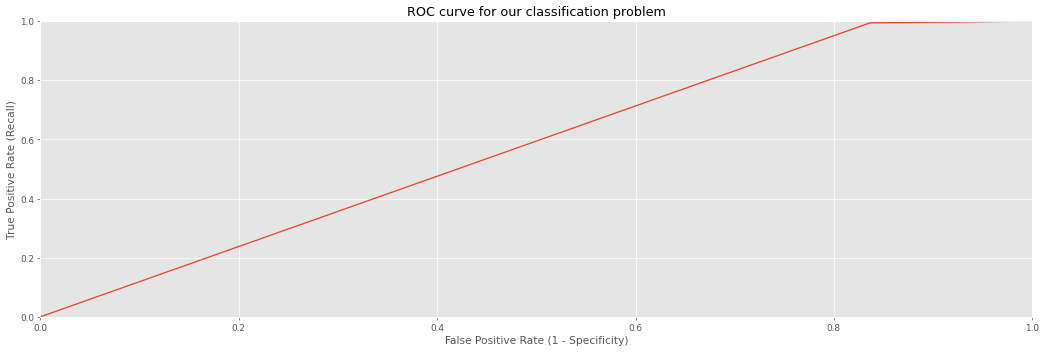

In [75]:
FP_rate, TP_rate, thresholds = sklearn.metrics.roc_curve(y_test, ŷ_test)
plt.plot(FP_rate, TP_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for our classification problem')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid(True)

Una línea diagonal desde la esquina inferior izquierda hasta la esquina superior derecha del gráfico representa un clasificador aleatorio. La curva ROC ideal abraza la esquina superior izquierda del gráfico, indicando una alta tasa de verdaderos positivos y una baja tasa de falsos positivos, lo que se traduce en una alta precisión.

El área bajo la curva ROC (AUC) es un resumen de un solo número del rendimiento del modelo. El AUC oscila entre $0$ y $1$, con un valor de $1$ que indica un rendimiento perfecto y un valor de $0,5$ que indica un rendimiento aleatorio. En general, un AUC más alto indica un mejor rendimiento del modelo.

In [76]:
sklearn.metrics.roc_auc_score(y_test, ŷ_test)

np.float64(0.578864170258405)

La curva ROC y el AUC son herramientas útiles para evaluar y comparar el rendimiento de distintos modelos de clasificación binaria, sobre todo cuando las clases están desequilibradas, es decir, una clase es mucho más frecuente que la otra. Permiten evaluar la capacidad de un modelo para distinguir entre dos clases y **comparar diferentes modelos de clasificación de forma objetiva**.

### Clasificación multiclase

La clasificación multiclase es un tipo de problema de aprendizaje automático cuyo objetivo es predecir la categoría o etiqueta de clase de una instancia de entrada a partir de un conjunto de clases posibles. En la clasificación multiclase, hay más de dos resultados o clases posibles a las que puede pertenecer una instancia, a diferencia de la clasificación binaria, en la que sólo hay dos clases posibles.

Por ejemplo, un problema de clasificación multiclase podría ser predecir la raza de un gato determinado en un conjunto de datos en el que hay tres clases posibles: «siamés», «persa» y «común europeo». Otro ejemplo podría ser predecir el género de una película a partir de un conjunto de géneros posibles: «acción», «comedia», «drama» y «ciencia ficción».

En la clasificación multiclase, **cada instancia** está **asociada a una etiqueta de clase** verdadera, y el objetivo del modelo de aprendizaje automático es aprender un mapeo entre las características de entrada y la etiqueta de clase correcta. Hay varios algoritmos que pueden utilizarse para la clasificación multiclase, como los árboles de decisión, las máquinas de vectores soporte, la regresión logística y las redes neuronales.

La evaluación de los modelos de clasificación multiclase suele realizarse utilizando métricas como la exactitud, la precisión, la recuperación y la puntuación F1. Ya hemos visto que la exactitud mide la proporción de predicciones correctas realizadas por el modelo, mientras que la precisión, la recuperación y la puntuación F1 proporcionan información más detallada sobre el rendimiento del modelo para cada clase.

Intentaremos resolver un problema como el anterior pero en el que hay más de dos clases.

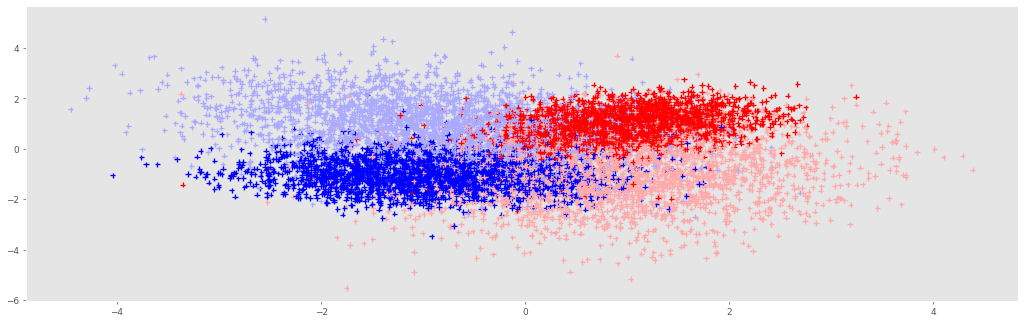

In [77]:
X, Y = sklearn.datasets.make_classification(
    n_samples=10000,
    n_features=2,
    n_redundant=0,
    n_classes=4,
    n_clusters_per_class=1,
)
plt.scatter(X[:,0], X[:,1], marker="+", c=Y, cmap='bwr');

También como antes, extraeremos un conjunto de entrenamiento y un conjunto de prueba para evaluar el modelo.

In [ ]:
x_train, y_train = X[:-1000,:], Y[:-1000]
x_test, y_test = X[-1000:,:], Y[-1000:]

plt.subplot(1, 2, 1)
plt.scatter(x_train[:,0], x_train[:,1], marker="+", c=y_train, cmap='bwr');
plt.title('Training set')
plt.subplot(1, 2, 2)
plt.scatter(x_test[:,0], x_test[:,1], marker="+", c=y_test, cmap='bwr');
plt.title('Test set');

#### El modelo de clasificación

Antes de crear el modelo, tenemos que echar un vistazo a los datos de salida. En la sección anterior, teníamos dos clases, y una sola neurona de salida era suficiente para discriminar entre una y otra ($0$ para una clase y $1$ para la otra).

Ahora, sin embargo, tenemos cuatro salidas en total. ¿Cómo podemos hacer que el modelo sea capaz de clasificar entre todas ellas? La respuesta es que no podemos. Necesitamos una neurona para cada clase, y cada neurona tendrá que tener un valor de salida entre $0$ y $1$. La neurona con el valor más alto será la que se active, y por tanto será la clase que se prediga.

Para ello, vamos a utilizar una función de activación llamada _softmax_. Esta función de activación es una generalización de la función sigmoide, y se utiliza para calcular la probabilidad de que un ejemplo pertenezca a una clase determinada. La función softmax se define como sigue:

$$
\sigma(z)_j = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}
$$

Siendo:

- $z$ el vector de entrada,
- $z_j$ es el valor de entrada de la neurona $j$, y
- $K$ es el número de clases.

La función softmax se aplica a cada neurona de salida, y el resultado es un vector de probabilidades que suman 1. Por lo tanto, para nuestro problema, tendremos que tener cuatro neuronas de salida, y cada una de ellas tendrá que tener un valor entre 0 y 1. La neurona con el valor más alto será la que active la capa _softmax_, y por lo tanto, será la clase que se prediga.

Sabiendo esto, vamos a crear el modelo:

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),
])
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()]
)
model.summary()

Fijémonos por un momento en el argumento de _loss_. En el ejemplo anterior hemos utilizado _binary_crossentropy_, que es la función de pérdida utilizada para problemas de clasificación binaria. En este caso, sin embargo, tenemos cuatro clases, y por lo tanto, necesitamos una función de pérdida que se adapte a este tipo de problema. En este caso, utilizaremos _categorical_crossentropy_.

Estas dos funciones son las mismas para los problemas de clasificación binaria. Sin embargo, _binary_crossentropy_ es más eficiente que _categorical_crossentropy_ para problemas de clasificación binaria, entre otras cosas porque no hay que hacer ninguna codificación _one-hot_ de la salida.

Pero, ¿en qué consiste esta codificación _one-hot_? Veamos la forma de las clases de nuestro conjunto de entrenamiento:

In [ ]:
print(y_train[:10])

Es sólo una salida numérica. En otras palabras, es una salida de dimensión 1, pero hemos definido la salida de nuestro modelo como de dimensión 4. Para ello tenemos que recodificar la salida de alguna manera que nos permita tener una salida de dimensión 4. Para ello tenemos que recodificar la salida de alguna manera que nos permita tener una salida de dimensión 4. Para ello utilizaremos la codificación _one-hot_ que conseguimos, por ejemplo, con la función `to_categorical` de `keras.utils`.

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
print(y_train[:,:10])

Como podemos ver, la salida de nuestro modelo es ahora una matriz de dimensión 4, donde cada fila es una clase y cada columna es un ejemplo. Cada fila tiene un 1 en la posición correspondiente a la clase que se predice, y un 0 en todas las demás posiciones.

Ahora vamos a entrenar el modelo:

In [ ]:
history = model.fit(x_train, y_train, batch_size=len(x_train), epochs=1000, validation_split=0.1, verbose=0)

Veamos su evaluación en un gráfico.

In [ ]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Bueno, no es exactamente una clasificación, pero al menos parece ser mejor que una clasificación aleatoria. Realicemos una predicción para trabajar con ella.

In [ ]:
ŷ_test = np.argmax(model.predict(x_test), axis=1)

Cabe destacar que hemos aplicado la función `argmax` sobre las filas para obtener la clase predicha. Esto se debe a que la salida de la capa _softmax_ es un vector de probabilidades, y queremos obtener la clase que tiene la mayor probabilidad.

Ahora hablemos un poco de las métricas de evaluación.

#### Métricas de evaluación para problemas de clasificación multiclase

En realidad, las métricas utilizadas en este tipo de problemas son las mismas que hemos visto para la clasificación binaria. Precisión, sensibilidad, exactitud, etc., son medidas que evalúan el acierto frente al error.

Sin embargo, merece la pena revisar la matriz de confusión para los casos en los que tenemos más de una clase. Vamos a ello.

##### Comprender una matriz de confusión multiclase

Mientras que una matriz de confusión de $2$ por $2$ es intuitiva y fácil de entender, las matrices de confusión más grandes pueden llegar a ser bastantes confusas.

Explorémoslas suponiendo que, en el ejemplo anterior, las cuatro clases corresponden a cuatro tipos distintos de pociones de vida resultantes de mezclar dos hierbas en distintas proporciones: excelente ($3$), grande ($2$), pequeña ($1$) y diminuta ($0$). La evaluación de cualquier clasificador sobre estos datos de diamante producirá una matriz de $4$ por $4$:

In [ ]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, ŷ_test)
plt.show()

Aunque la interpretación de la matriz de confusión se vuelve más y más complicada a medida que aumenta el número de clases, existe un método para simplificar conceptualmente el entendimieto de cualquier tipo de matriz, independientemente de su tamaño.

Lo primero que hay que hacer es identificar qué clases son positivas y cuáles son negativas. Esto depende de la tarea a resolver, y no siempre es obvio. Si la clasificación es equilibrada, es decir, si cada clase es igual de importante, puede que no haya clases positivas ni negativas, pero este no suele ser el caso, y siempre suele haber clases que son más o menos interesantes para nuestra tarea.

En nuestro ejemplo, como aventureros acérrimos que somos, nos interesa que la red neuronal implementada en nuestra varita de identificación de pociones clasifique mejor las pociones excelentes y grandes que las pequeñas y diminutas, principalmente porque el tamaño de la mochila es limitado y son las que nos mantendrán vivo más tiempo. En este caso, las etiquetas _ideal_ y _premium_ constituirán una clase positiva, y las demás etiquetas se considerarán negativas.

Después de eso, podemos pasar a definir los términos de la matriz de confusión:

1. **Verdaderos positivos**: Aquellos casos donde la poción real y la predicha son _excelente_ (tipo 1) o _grande_ (tipo 2),
2. **Verdaderos negativos**: Aquellos casos donde cualquier etiqueta considerada negativa ha sido correctamente predicha,
3. **Falsos positivos**: La poción es _pequeña_ o _minúscula_, pero ha sido predicha como _grande_ o _excelente_, y
4. **Falsos negativos**: La poción es _grande_ o _excelente_, pero ha sido predicha como _pequeña_ o _diminuta_.

Habiendo definido los 4 términos, encontrar cada uno de ellos en la matriz debería ser fácil. Y a partir de ahí, se pueden definir las medidas que hemos discutido previamente.

##### Una nota sobre diferentes estrategias de clasificación multiclase

Aquí hemos resuelto el problema de clasificación multiclase de una manera muy específica: estableciendo una correspondencia entre cada una de las clases con cada una de las neuronas de salida, denotando estas la probabilidad de que un ejemplo pertenezca o no a la clase que representan. Esta estrategia es un tipo dentro de lo que se conoce como _transformación binaria_ de la salida y vamos a hablar un poco sobre ello.

Hay algoritmos que están específicamente diseñados para resolver problemas de clasificación binaria, como las redes neuronales. Cuando tenemos una única clase y queremos clasificar si un ejemplo pertenece o no a una clase determinada, basta con una neurona. Sin embargo, si tenemos más clases, existen principalmente Una neurona si tenemos dos clases y varias neuronas si tenemos más. La estrategia de transformación binaria se subdivide en dos, dependiendo del número de neuronas que usamos para la salida.

###### Estrategia uno contra todos (OVR, del inglés _one-vs-rest_)

También conociada como uno contra todos (OVA, del inglés _one-vs-all_). En este caso, tenemos **una neurona para cada clase**, y cada neurona indica la probabilidad de que un ejemplo pertenezca a esa clase. Por ejemplo, si en un problema de clasificación de imágenes tenemos las clases `Perro`, `Gato`, `Caballo` y `Vaca`, tendremos cuatro neuronas de salida:

- Neurona 1: `Perro` vs. (`Gato`, `Caballo`, `Vaca`),
- Neurona 2: `Gato` vs. (`Perro`, `Caballo`, `Vaca`),
- Neurona 3: `Caballo` vs. (`Perro`, `Gato`, `Vaca`), y
- Neurona 4: `Vaca` vs. (`Perro`, `Gato`, `Caballo`).

Esta es la estrategia que hemos utilizado y se llama así porque una clase vence al resto en cada clasificación. Suele ser la más extendida.

###### Estrategia uno contra uno (OVO, del inglés _one-vs-one_)

En este caso, tenemos **una neurona para cada par de clases**. En este caso, tendremos $\frac{N(N-1)}{2}$ neuronas de salida, y cada neurona indica la probabilidad de que un ejemplo pertenezca a una clase frente a otra. Con esta estrategia tendremos un total de 6 neuronas para el mismo ejemplo de antes.

In this case, we have one neuron for each pair of classes, i.e. $\frac{N(N-1)}{2}$, and each neuron indicates the probability that an example belongs to one class versus the other. With this strategy we get a total of 6 neurons for the same example.

- Neurona 1: `Perro` vs. `Gato`
- Neurona 2: `Perro` vs. `Caballo`
- Neurona 3: `Perro` vs. `Vaca`
- Neurona 4: `Gato` vs. `Caballo`
- Neurona 5: `Gato` vs. `Vaca`
- Neurona 6: `Caballo` vs. `Vaca`

Esta estrategia se usa a menudo en [SVM](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte), otra técnica de clasificación.

### Clasificación multietiqueta

En la clasificación multietiqueta, el objetivo es predecir múltiples etiquetas binarias o atributos para una instancia de entrada dada. A diferencia de la clasificación multiclase, donde una instancia se asigna a una sola clase, **la clasificación multietiqueta asigna una instancia a una o más clases**.

Por ejemplo, en un problema de clasificación multietiqueta de reconocimiento de imágenes, una imagen puede tener múltiples objetos o atributos que pueden ser reconocidos, como `gato`, `perro`, `interior`, `exterior`, `diurno` y `nocturno`. Así, una imagen puede ser asignada múltiples etiquetas al mismo tiempo.

En la clasificación multietiqueta, cada ejemplo puede estar asociado con múltiples etiquetas binarias, y el modelo tiene como objetivo aprender un mapeo entre las características de entrada y el conjunto correcto de etiquetas. Hay varios algoritmos que se pueden utilizar para la clasificación multietiqueta, como $k$-vecinos más cercanos, árboles de decisión, _random forest_ y redes neuronales.

El problema a resolver será similar al anterior sólo que cada ejemplo podrá pertenecer a varias clases de las existentes:

In [ ]:
X, Y = sklearn.datasets.make_multilabel_classification(
    n_samples=10000,
    n_features=2,
    n_classes=4,
    n_labels=1,
)
Y_colors = Y[:,0] + 2*Y[:,1] + 4*Y[:,2] + 8*Y[:,3]
plt.scatter(X[:,0], X[:,1], marker="+", c=Y_colors, cmap='bwr');

Al igual que antes, extraeremos un conjunto de entrenamiento y un conjunto de prueba para evaluar el modelo.

In [ ]:
x_train, y_train = X[:-1000,:], Y[:-1000]
y_train_colors = y_train[:,0] + 2*y_train[:,1] + 4*y_train[:,2] + 8*y_train[:,3]
x_test, y_test = X[-1000:,:], Y[-1000:]
y_test_colors = y_test[:,0] + 2*y_test[:,1] + 4*y_test[:,2] + 8*y_test[:,3]

plt.subplot(1, 2, 1)
plt.scatter(x_train[:,0], x_train[:,1], marker="+", c=y_train_colors, cmap='bwr');
plt.title('Training set')
plt.subplot(1, 2, 2)
plt.scatter(x_test[:,0], x_test[:,1], marker="+", c=y_test_colors, cmap='bwr');
plt.title('Test set');

#### Modelo de clasificación

Implementar un modelo de clasificación multietiqueta es muy similar a un problema de clasificación multiclase. Sin embargo en este caso, una capa _softmax_ en la salida y una entropía cruzada como _loss__ en la salida única no son válidas porque, por definición, puede haber más de una salida.

En cambio, cada salida va a ser independiente, es decir, cada neurona de salida corresponderá a una clase y no habrá una capa posterior que las una. Para calcular la pérdida, utilizaremos una entropía cruzada (a saber, una entropía cruzada binaria) que se calculará para cada salida diferente a la vez. De esta manera, los errores de cada salida se calcularán por separado para cada una de las clases.

Sabiendo esto, vamos a crear el modelo:

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid'),
])
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.SGD(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)
model.summary()

Hemos hecho un poco de trampa porque este problema es un poco más complejo y requiere un modelo más potente.

Estas cuatro salidas corresponderán a la codificación de nuestras cuatro clases, y cada una de ellas tendrá una salida independiente. En este caso, la salida será un número entre 0 y 1 que indica la probabilidad de que el ejemplo pertenezca a esa clase:

In [ ]:
print(y_train[:,:10])

La codificación es similar a la que hemos hecho antes (_one-hot encoding_), pero en este caso, cada fila puede tener más de un 1. En ocasiones es nombrada _multi-hot encoding_.

Ahora sólo nos queda entrenar el modelo:

In [ ]:
history = model.fit(x_train, y_train, batch_size=len(x_train), epochs=1000, validation_split=0.1, verbose=0)

Vamos a ver cómo ha evolucionado el proceso de entrenamiento:

In [ ]:
pd.DataFrame(history.history).plot()
plt.xlabel('Epoch num.')
plt.show()

Por lo visto parece que el modelo ha aprendido algo, aunque la evolución del _loss_ no es para emocionarse. Aún así, por ejemplo, es suficiente para nosotros.

In [ ]:
ŷ_test = (model.predict(x_test) > 0.5).astype(int)
print(ŷ_test)

#### Métricas de evaluación para problemas de clasificación multietiqueta

A diferencia de los problemas de clasificación binaria y multiclase, en los que cada instancia está asociada a una única etiqueta de clase, en la clasificación multietiqueta, cada instancia puede estar asociada a múltiples etiquetas binarias. Por lo tanto, las métricas de evaluación utilizadas en la clasificación multietiqueta son diferentes de las utilizadas en los problemas de clasificación binaria y multiclase.

Generalmente, esto se hace utilizando métricas como la precisión, la exactitud, el _recall_ y el F1 _score_, que pueden calcularse para cada etiqueta por separado o para el conjunto total de etiquetas. Sin embargo, hay otras métricas que pueden darnos algunas indicaciones de cómo los modelos están realizando su tarea.

Estas métricas pueden calcularse por separado para cada etiqueta o para el conjunto total de etiquetas. Dependiendo del problema específico y del dominio, diferentes métricas pueden ser más apropiadas. Por lo tanto, es importante elegir cuidadosamente las métricas de clasificación multietiqueta apropiadas para evaluar el rendimiento de un modelo dado.

##### Macropromedio

Consiste en calcular una métrica (por ejemplo, precisión, _recall_ o F1 _score_) para cada etiqueta por separado, y luego tomar la media de todas las métricas. Esta métrica da el mismo peso a cada etiqueta, independientemente de su frecuencia en el conjunto de datos.

$$
macro(f, y, \hat{y}) = \sum_{l \in L} f(y, \hat{y}, l)
$$

Siendo $L$ el conjunto de etiquetas o clases y $l$ la métrica. Por ejemplo, dado que queremos calcular el promedio macro para la precisión, tenemos:

In [ ]:
def precision(y, ŷ, label=1):
    TP = np.sum((ŷ_test == label) & (y_test == label))
    FP = np.sum((ŷ_test == label) & (y_test != label))
    return TP / (TP + FP)

def macro(metric, y, ŷ, labels=None):
    labels = labels or np.unique(y)
    return np.mean([metric(y, ŷ, label) for label in labels])

print(f'Macro precision = {macro(precision, y_test, ŷ_test):.02}')

Especial atención a que hemos reescrito la función de precisión para que ahora tenga en cuenta la etiqueta. Dado que estamos tratando con un problema de más de una clase, es necesario indicar sobre qué etiqueta queremos trabajar.

##### Micropromedio

En esta medida se calcula la métrica considerando todos los ejemplos y etiquetas juntas. Esta métrica da el mismo peso a cada ejemplo y a cada etiqueta, independientemente de su frecuencia en el conjunto de datos.

Por supuesto depende de la métrica a calcular, por lo que por ejemplo, para la precisión, tendríamos lo siguiente:

$$
\mu Pre = \frac{\sum_{l in L}TP_l}{\sum_{l in L}TP_l + \sum_{l in L}FP_l}
$$

Lo cual se puede implementar de la siguiente manera:

In [ ]:
def micro_precision(y, ŷ, labels=None):
    labels = labels or np.unique(y)
    TP = np.sum([(ŷ_test == label) & (y_test == label) for label in labels])
    FP = np.sum([(ŷ_test == label) & (y_test != label) for label in labels])
    return TP / (TP + FP)

print(f'Micro precision = {micro_precision(y_test, ŷ_test):.02}')

##### Ratio de coincidencia exacta (EMR del inglés _exact match ratio_) y 1/0 _loss_

Esta métrica es bastante simple y es una extensión del concepto de precisión. Se define como:

$$
EMR(y, \hat{y}) = \frac{1}{n} \sum_{i = 0}^n I(y_i = \hat{y_i})
$$

Donde $I$ es una función (denominada «indicador») que devuelve $1$ o $0$ si el argumento es `true` o `false` respectivamente, $n$ es el número de ejemplos en el conjunto de entrenamiento, $y$ es el vector de etiquetas verdaderas e $\hat{y}$ es el vector de etiquetas predichas.

En otras palabras, el ratio de coincidencia exacta es la proporción de ejemplos en los que todas las etiquetas verdaderas coinciden con todas las etiquetas predichas. Por ejemplo, si tenemos un conjunto de datos con $100$ ejemplos, y en $80$ de ellos todas las etiquetas verdaderas coinciden con todas las etiquetas predichas, el ratio de coincidencia exacta sería de $0,8$.

Una posible implementación de esta métrica sería:

In [ ]:
def emr(y, ŷ):
    return np.sum(y == ŷ) / len(y)

print(f'EMR = {emr(y_test, ŷ_test):.02}')

El ratio de coincidencia exacta es una métrica útil para evaluar el rendimiento de un modelo de clasificación multietiqueta, ya que proporciona una medida de cuántos ejemplos se clasifican correctamente en términos de todas las etiquetas.

El principal inconveniente de esta medida es que no tiene en cuenta las etiquetas parcialmente correctas. Es decir, o es 100% correcta o no es correcta en absoluto. Por ejemplo, si estamos clasificando imágenes de perros y gatos, y el sistema predice que hay un perro y un gato en la imagen, pero en realidad hay un perro y un caballo, la medida EMR dará un 0.

Por ello, a partir de esta métrica se define el _loss_ 1/0, que se define como:

$$
L_{01}(y, \hat{y}) = 1 - EMR(y, \hat{y})
$$

Dicho de otro modo, el _loss_ 1/0 es simplemente el complemento de la medida EMR. Es una medida útil para evaluar el rendimiento de un modelo de clasificación multietiqueta, ya que proporciona una medida de cuántos ejemplos se clasifican incorrectamente en términos de todas las etiquetas.

Sin embargo, esta función de _loss_ tiene el problema de que, como no es diferenciable, no se puede utilizar en la mayoría de los algoritmos de aprendizaje automático. Pero la ponemos aquí para conocer de su existencia, no vaya a ser que nos la encontremos en algún sitio y no sepamos qué significa.

##### _Hamming loss_ (HL)

Se define como la fracción de etiquetas que se predicen incorrectamente, es decir, la fracción de etiquetas incorrectas con respecto al número total de etiquetas:

$$
HL(y, ŷ) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{L} \sum_{j=1}^{L} I(y_{ij} \neq \hat{y}_{ij})
$$

Una posible implementación de esta métrica sería:

In [ ]:
def hamming_loss(y, ŷ):
    return np.sum(y | ŷ) / np.prod(y.shape)

print(f'Hamming loss = {hamming_loss(y_test, ŷ_test):.02}')

Se puede observar que se trata de una extensión de la métrica 1/0 _loss_, pero teniendo en cuenta esta vez las etiquetas parcialmente correctas. Esto es, si el sistema predice que hay un perro y un gato en la imagen, pero en realidad hay un perro y un caballo, la métrica HL dará un 0.5 y no un 1.

##### Coeficiente de similitud de Jaccard

Se usa para cómo de parecido son dos conjuntos. En el contexto de la clasificación multietiqueta, se utiliza para medir cuán similares son las etiquetas verdaderas y las predichas. Se define como:

$$
J(y, \hat{y}) = \frac{|y \cap \hat{y}|}{|y \cup \hat{y}|}
$$

Dicho de otro modo, el coeficiente de similitud de Jaccard es la proporción de la intersección de las etiquetas verdaderas y las predichas con respecto a la unión de las etiquetas verdaderas y las predichas. Por ejemplo, si tenemos un conjunto de etiquetas verdaderas y predichas, y la intersección de las dos es de 10 y la unión de las dos es de 20, el coeficiente de similitud de Jaccard sería de 0,5.

Una posible implementación de esta métrica sería:

In [ ]:
def jaccard_score(y_true, y_pred):
    # Compute intersection and union of true and predicted labels
    inter = np.sum(y_true & y_pred, axis=1)
    union = np.sum(y_true | y_pred, axis=1)
    
    jaccard = np.divide(
        inter,
        union,
        out=np.zeros_like(inter),
        where=union!=0,
        casting='unsafe'
    )
    
    return np.mean(jaccard)

print(f'Jaccard score = {jaccard_score(y_test, ŷ_test):.02}')

El coeficiente de similitud de Jaccard toma valores entre $0 y 1$, donde $1$ indica una similitud perfecta entre las etiquetas verdaderas y las predichas, y $0$ indica que no hay similitud entre las etiquetas verdaderas y las predichas. Un valor de $0,5$ indica, por tanto, que la mitad de las etiquetas verdaderas y predichas coinciden.

## Conclusiones

Este _notebook_ ha sido intensito, pero en él hemos visto las principales diferencias de los dos tipos de problemas con los que nos encontraremos en problemas de aprendizaje profundo: clasificación y regresión. Los modelos desarrollados para estos son muy similares, variando básicamente en la salida y su cálculo de error.

Además, para la evaluación de estos modelos hemos presentado algunas medidas, algunas específicas para la clasificación y otras para la regresión. Lo bueno es que prácticamente todos los _frameworks_ incluyen estas implementaciones, probablemente mucho mejor de lo que nosotros mismos podríamos implementarlas. Sin embargo, es muy importante saber cómo estamos midiendo y qué significan esas mediciones.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>